We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. \



#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new in computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes? Assuming independence between attributes means we treat each attribute as if it doesn’t influence or depend on any other attribute 

In [1]:

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import corner
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('galaxyquasar.csv')

In [3]:
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
ug = np.array(df['u']-df['g'])
gr = np.array(df['g']-df['r'])
ri = np.array(df['r']-df['i'])
iz = np.array(df['i']-df['z'])

labels = np.where(df['class'] == 'QSO', 1, 0)

In [14]:
X = np.column_stack((ug, gr, ri, iz)) #my features
X_train, X_test, lab_train, lab_test = train_test_split(X, labels, test_size=0.3, random_state=4)


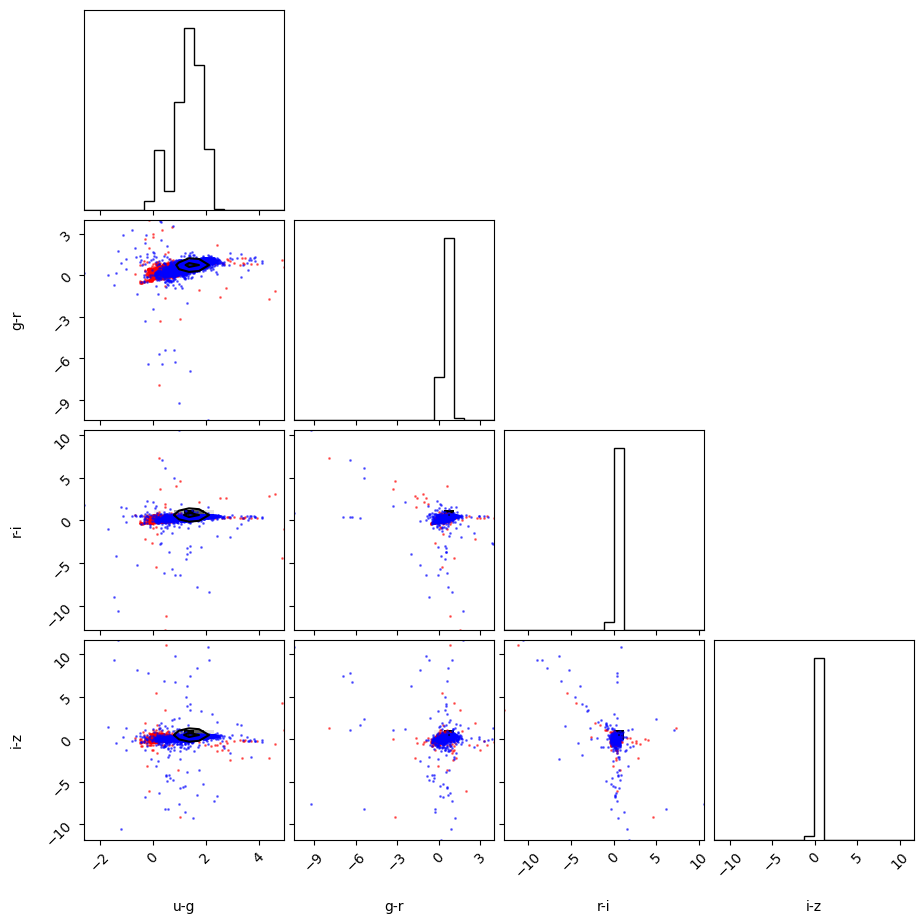

In [7]:
#data exploration looking for correlation features

figure = corner.corner(X, labels=["u-g", "g-r", "r-i", "i-z"], plot_datapoints=False)

axes = np.array(figure.axes).reshape((4, 4))

for i in range(4):
    for j in range(i):
        ax = axes[i, j]
        ax.scatter(X[labels == 1, j], X[labels == 1, i], color="red", s=1, label="QSO", alpha=0.5)
        ax.scatter(X[labels == 0, j], X[labels == 0, i], color="blue", s=1, label="Galaxy", alpha=0.5)

plt.show()

seems like u-g is the best features for classification, but is also show a strong correlation between the others feature, so I expect the Naive Bayes classifier to better perform with just the u-g feature, instead of using all the features.

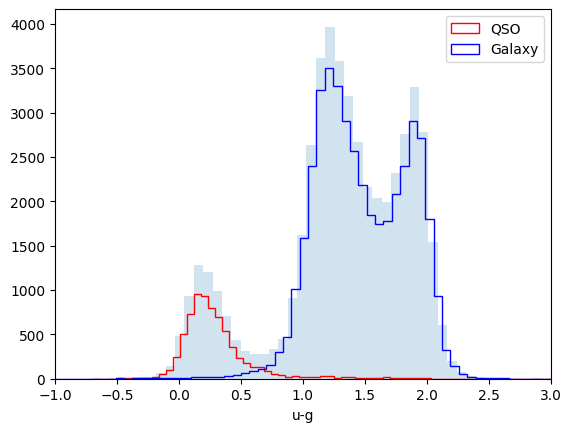

In [8]:
#histogram of u-g
plt.hist(ug, bins=100, alpha=0.2)
plt.hist(ug[labels==1], histtype='step', bins=100, label='QSO', color='red')
plt.hist(ug[labels==0], histtype='step', bins=100, label='Galaxy', color='blue')
plt.xlim(-1,3)
plt.xlabel('u-g')
plt.legend()
plt.show()

## Gaussian Naive Bayes

Gaussian Naive Bayes 
Completeness = [0.92881032 0.92881032 0.92546584 0.92355471] 
Contamination = [0.06313253 0.10702802 0.10572484 0.11330275]


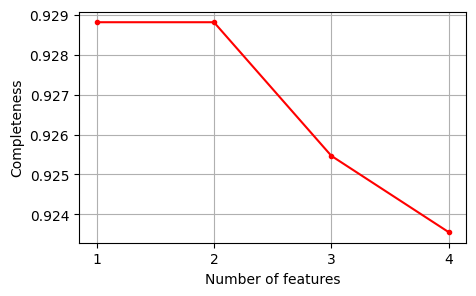

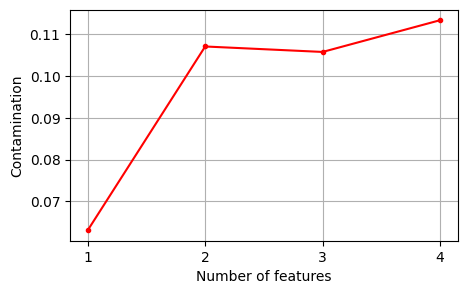

In [17]:
feat = np.linspace(1,4,4)
lab_prob = []
lab_pred = []

for x in feat: #fit for each features
    
    gnb = GaussianNB(priors=None)
    gnb.fit(X_train[:,:int(x)],lab_train)
    
    pred_labels = gnb.predict(X_test[:, :int(x)])
    pred_probs = gnb.predict_proba(X_test[:, :int(x)])[:, 1] #returns class probabilities for each sample in the input.
    
    lab_pred.append(pred_labels)
    lab_prob.append(pred_probs)

completeness, contamination = completeness_contamination(lab_pred, lab_test)
print(f'Gaussian Naive Bayes \nCompleteness = {completeness} \nContamination = {contamination}')

plt.figure(figsize=(5,3))
plt.plot(feat, completeness, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Completeness')
plt.xticks(feat)
plt.grid()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(feat, contamination, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Contamination')
plt.xticks(feat)
plt.grid()
plt.show()

 Adding features my model is getting worst: this is due to the correlation between ug and thhe others features!

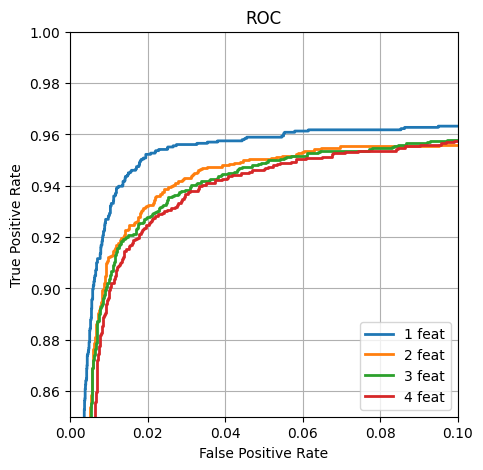

In [18]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob[int(i-1)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{int(i)} feat')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
accuracy_ug = accuracy_score(lab_test, lab_pred[0])
print(f"Accuracy of gauss naive considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred[-1])
print(f"Accuracy gauss naive considering all the features: {accuracy:.4f}")

Accuracy of gauss naive considering only u-g feature: 0.9813
Accuracy gauss naive considering all the features: 0.9729


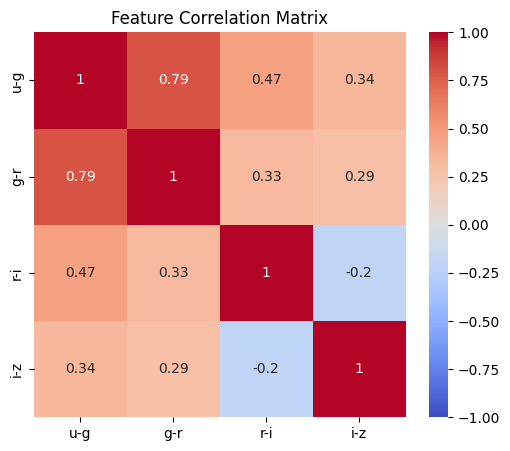

In [20]:
df = pd.DataFrame(X_train, columns=['u-g', 'g-r', 'r-i', 'i-z'])
corr_matrix = df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

we can clearly see that the first and the second features are highly correlated, which is coherent with the result that we get from gaussian naive classifier that assumes all the features as independent. In fact the result is more accurate using the first feature alone rather than using it in combination with the second

## Linear and Quadratic Discriminant Analysis

Linear DA 
Completeness = [0.93119924 0.92737697 0.92833254 0.92737697], Contamination = [0.06433029 0.06095791 0.06044487 0.05913718]
Quadratic DA 
Completeness = [0.92881032 0.93119924 0.92881032 0.92689919], Contamination = [0.06313253 0.06072289 0.06177606 0.06370656]


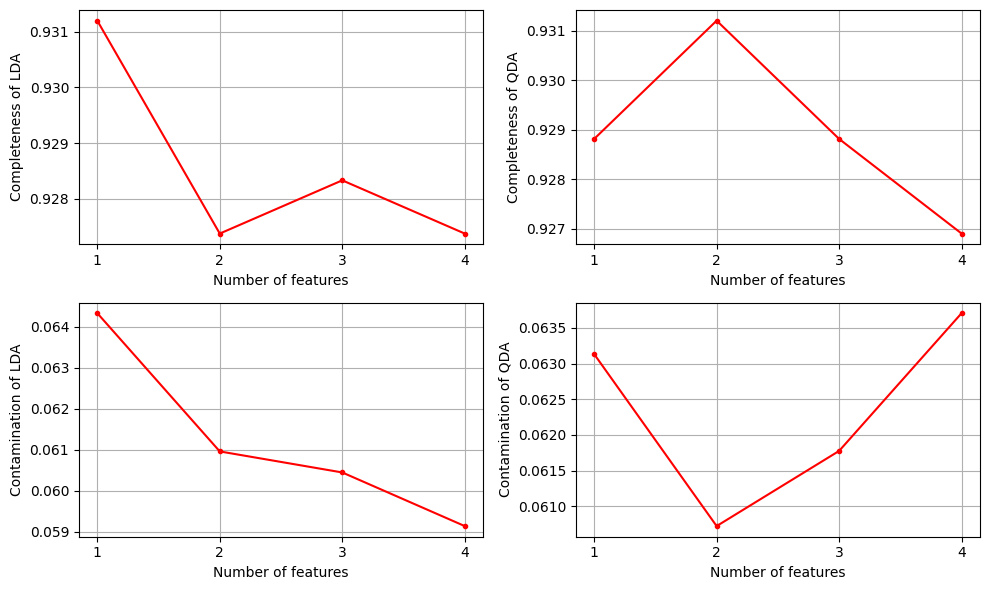

In [21]:
lab_prob_l = []
lab_pred_l = []
lab_prob_q = []
lab_pred_q = []

for x in feat:
    
    lda = LDA()
    lda.fit(X_train[:,:int(x)],lab_train)
    
    lab_pred_l.append(lda.predict(X_test[:, :int(x)]))
    lab_prob_l.append(lda.predict_proba(X_test[:, :int(x)])[:, 1])

    qda = QDA()
    qda.fit(X_train[:,:int(x)],lab_train)
    
    lab_pred_q.append(qda.predict(X_test[:, :int(x)]))
    lab_prob_q.append(qda.predict_proba(X_test[:, :int(x)])[:, 1])
    

completeness_l, contamination_l = completeness_contamination(lab_pred_l, lab_test)
print(f'Linear DA \nCompleteness = {completeness_l}, Contamination = {contamination_l}')


completeness_q, contamination_q = completeness_contamination(lab_pred_q, lab_test)
print(f'Quadratic DA \nCompleteness = {completeness_q}, Contamination = {contamination_q}')

plt.figure(figsize=(10, 6))


plt.subplot(2, 2, 1)
plt.plot(feat, completeness_l, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Completeness of LDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 2)
plt.plot(feat, completeness_q, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Completeness of QDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 3)
plt.plot(feat, contamination_l, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Contamination of LDA')
plt.grid()
plt.xticks(feat)


plt.subplot(2, 2, 4)
plt.plot(feat, contamination_q, marker='.', color='red')
plt.xlabel('Number of features')
plt.ylabel('Contamination of QDA')
plt.grid()
plt.xticks(feat)

plt.tight_layout()
plt.show()

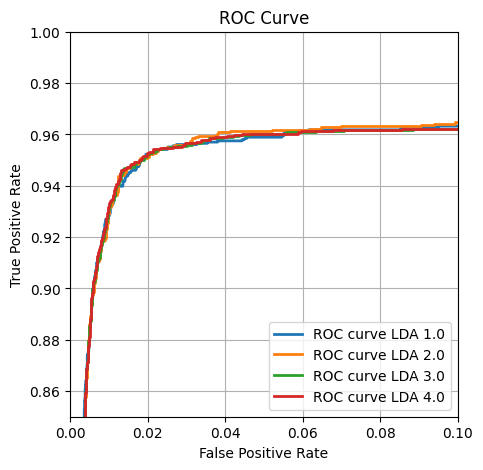

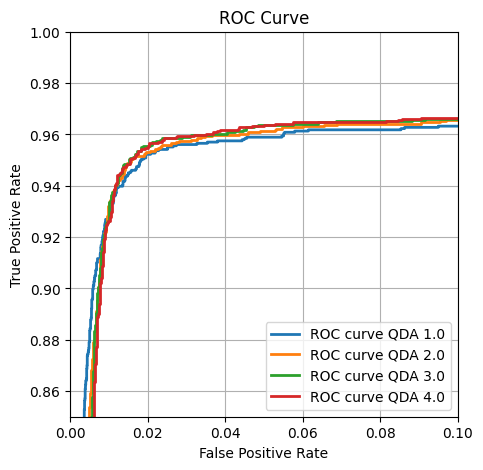

In [22]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob_l[int(i)-1])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve LDA {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(5, 5))

for i in feat:
    fpr, tpr, _ = roc_curve(lab_test, lab_prob_q[int(i)-1])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve QDA {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [23]:
accuracy_ug = accuracy_score(lab_test, lab_pred_l[0])
print(f"Accuracy of LDA considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_l[3])
print(f"Accuracy of LDA considering all the features: {accuracy:.4f}")

Accuracy of LDA considering only u-g feature: 0.9815
Accuracy of LDA considering all the features: 0.9817


In [24]:
accuracy_ug = accuracy_score(lab_test, lab_pred_q[0])
print(f"Accuracy of QDA considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_q[3])
print(f"Accuracy of QDA considering all the features: {accuracy:.4f}")

Accuracy of QDA considering only u-g feature: 0.9813
Accuracy of QDA considering all the features: 0.9810


With all the features they do better than a naive gaussian because they do not implicate independency betweeen attributes. they perform really similarly because class covariances are actually similar (similar shape in the corner plots before)

## GMM Bayes

GMM with 1 component 
Completeness = [0.92881032 0.93119924 0.92881032 0.92689919] 
Contamination = [0.06313253 0.06072289 0.06177606 0.06370656]

GMM with 5 components 
Completeness = [0.93311037 0.92307692 0.93932155 0.92594362] 
Contamination = [0.07264957 0.0524767  0.05978001 0.0592233 ]


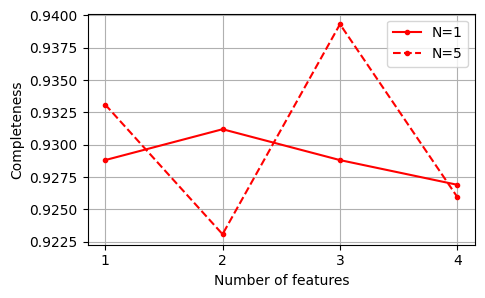

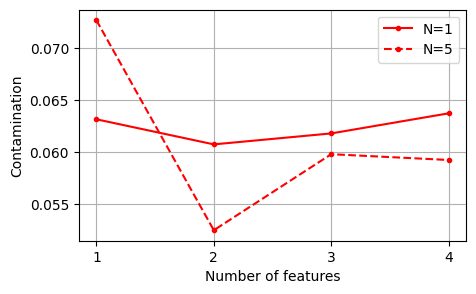

In [26]:
lab_pred_gmm = []
lab_prob_gmm = []
clusters = [1,5] #number of gaussian componenets

for c in clusters:
    
    for x in feat:
        
        gmm = GMMBayes(c, covariance_type='full') #c comopnents (number of clusters) 
        gmm.fit(X_train[:, :int(x)], lab_train)
        
        pred_labels = gmm.predict(X_test[:, :int(x)])
        pred_probs = gmm.predict_proba(X_test[:, :int(x)])[:, 1] #of being a QSO
        
        lab_pred_gmm.append(pred_labels)
        lab_prob_gmm.append(pred_probs)



completeness, contamination = completeness_contamination(lab_pred_gmm, lab_test)
print(f'GMM with 1 component \nCompleteness = {completeness[:4]} \nContamination = {contamination[:4]}\n')
print(f'GMM with 5 components \nCompleteness = {completeness[4:]} \nContamination = {contamination[4:]}')

plt.figure(figsize=(5,3))
plt.plot(feat, completeness[:4], marker='.', color='red', label='N=1')
plt.plot(feat, completeness[4:], marker='.', linestyle='--', color='red', label='N=5')
plt.xlabel('Number of features')
plt.ylabel('Completeness')
plt.grid()
plt.legend()
plt.xticks(feat)
plt.show()

plt.figure(figsize=(5,3))
plt.plot(feat, contamination[:4], marker='.', color='red', label='N=1')
plt.plot(feat, contamination[4:], marker='.', linestyle='--', color='red', label='N=5')
plt.xlabel('Number of features')
plt.ylabel('Contamination')
plt.grid()
plt.legend()
plt.xticks(feat)
plt.show()

| Indice | n_cluster | n_feature | Descrizione |
|:------:|:----------:|:----------:|:-------------|
| 0 | 1 | feat[0] | GMM con 1 componente, 1° feature set |
| 1 | 1 | feat[1] | GMM con 1 componente, 2° feature set |
| 2 | 1 | feat[2] | GMM con 1 componente, 3° feature set |
| … | … | … | … |
| n | 5 | feat[0] | GMM con 5 componenti, 1° feature set |
| n+1 | 5 | feat[1] | GMM con 5 componenti, 2° feature set |
| n+2 | 5 | feat[2] | GMM con 5 componenti, 3° feature set |

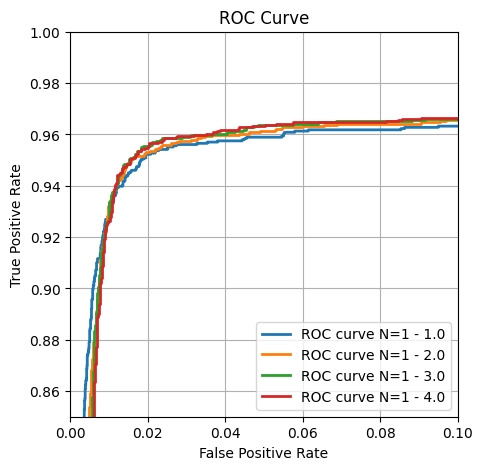

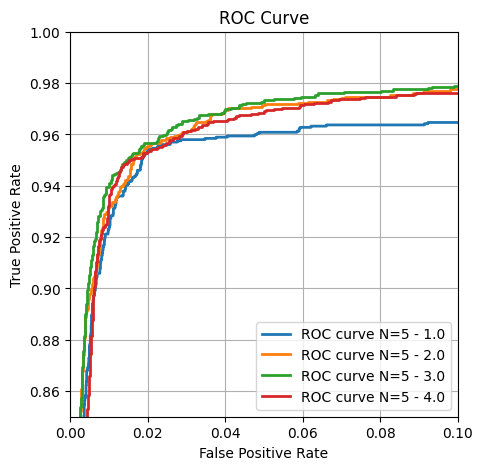

In [30]:
plt.figure(figsize=(5, 5))

for i in feat:
    fpr_1, tpr_1, _ = roc_curve(lab_test, lab_prob_gmm[int(i)-1])  
    plt.plot(fpr_1, tpr_1, lw=2, label=f'ROC curve N=1 - {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

plt.figure(figsize=(5, 5))

for i in feat:
    fpr_5, tpr_5, _ = roc_curve(lab_test, lab_prob_gmm[int(i)+3])
    plt.plot(fpr_5, tpr_5, lw=2, label=f'ROC curve N=5 - {i}')

plt.xlim([0.0, 0.1])
plt.ylim([0.85, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [31]:
accuracy_ug = accuracy_score(lab_test, lab_pred_gmm[0])
print(f"Accuracy of GMM (N=1) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_gmm[3])
print(f"Accuracy of GMM (N=1) considering all the features: {accuracy:.4f}")

Accuracy of GMM (N=1) considering only u-g feature: 0.9813
Accuracy of GMM (N=1) considering all the features: 0.9810


In [32]:
accuracy_ug = accuracy_score(lab_test, lab_pred_gmm[4])
print(f"Accuracy of GMM (N=5) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_gmm[7])
print(f"Accuracy of GMM (N=5) considering all the features: {accuracy:.4f}")

Accuracy of GMM (N=5) considering only u-g feature: 0.9805
Accuracy of GMM (N=5) considering all the features: 0.9815


## K nearest neigh with cross validation on number of neighbors

•	Small k → low bias, high variance (can overfit).
•	Large k → high bias, low variance (can underfit).

/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_65283/1378179513.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


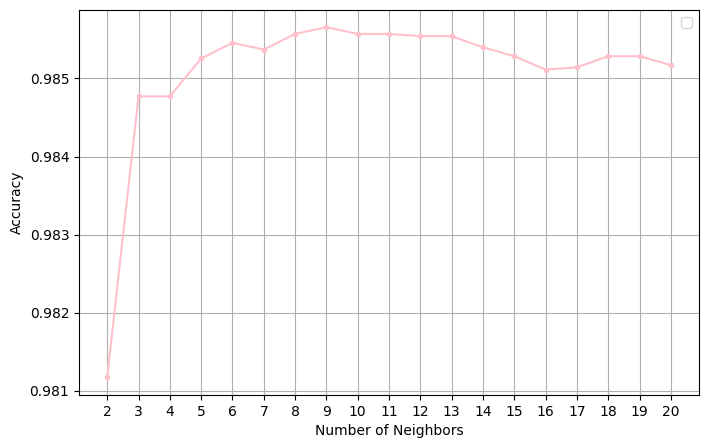

Best number of neighbors: 9 with accuracy: 0.9856571428571428
KNN with N=9 
Completeness = [0.92785475 0.92737697 0.93741042 0.94123268] 
Contamination = [0.06499759 0.05639281 0.04664723 0.03855539]


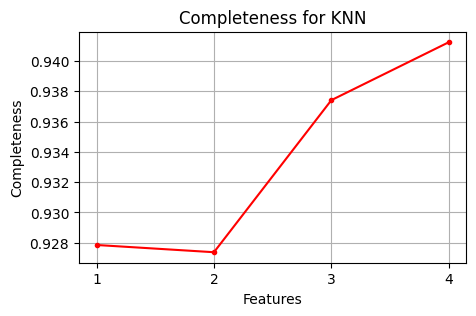

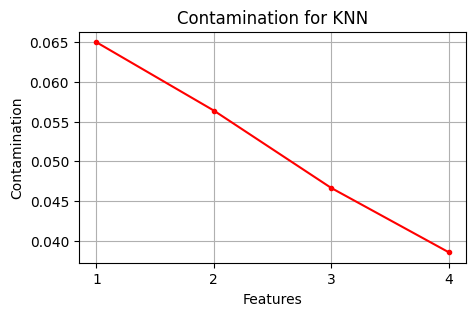

In [34]:
param_grid = {
    'n_neighbors': range(2, 21)  
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True) 

grid_search.fit(X_train, lab_train)

train_scores = grid_search.cv_results_['mean_train_score']
val_scores = grid_search.cv_results_['mean_test_score'] #average accuracy on validation folds
neighbors = grid_search.cv_results_['param_n_neighbors'].data

plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), val_scores, marker='.', color='pink')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(2,21))
plt.grid()
plt.show()

best_k = grid_search.best_params_['n_neighbors'] #best_k è il numero di vicini che massimizza l’accuratezza media sui fold di validazione.
best_score = grid_search.best_score_

print(f'Best number of neighbors: {best_k} with accuracy: {best_score}')
knn_best = KNeighborsClassifier(n_neighbors=best_k)

lab_pred_kn = []
lab_prob_kn = []

for x in feat:
        knn_best.fit(X_train[:, :int(x)],lab_train)
       
        pred_labels = knn_best.predict(X_test[:, :int(x)])
        pred_probs = knn_best.predict_proba(X_test[:, :int(x)])[:, 1]
        
        lab_pred_kn.append(pred_labels)
        lab_prob_kn.append(pred_probs)


completeness, contamination = completeness_contamination(lab_pred_kn, lab_test)
print(f'KNN with N={best_k} \nCompleteness = {completeness} \nContamination = {contamination}')

plt.figure(figsize=(5, 3))
plt.plot(feat, completeness, marker='.', color='red')
plt.xlabel('Features')
plt.ylabel('Completeness')
plt.grid()
plt.title('Completeness for KNN')
plt.xticks(feat)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(feat, contamination, marker='.', color='red')
plt.xlabel('Features')
plt.ylabel('Contamination')
plt.grid()
plt.title('Contamination for KNN')
plt.xticks(feat)
plt.show()

In [35]:
accuracy_ug = accuracy_score(lab_test, lab_pred_kn[0])
print(f"Accuracy of KNN (N={best_k}) considering only u-g feature: {accuracy_ug:.4f}")
accuracy = accuracy_score(lab_test, lab_pred_kn[3])
print(f"Accuracy of KNN (N={best_k}) considering all the features: {accuracy:.4f}")

Accuracy of KNN (N=9) considering only u-g feature: 0.9809
Accuracy of KNN (N=9) considering all the features: 0.9865
